In [91]:
import cv2
import numpy as np
import imutils
from utils.cttutils import displayImage
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours

In [92]:
side_b, side_m, top_b, top_m = 20.3059886137, -0.0179589246428, 11.9336384688, 0.0041337541737

def calculatePpm(x, m, b):
    ppm = x*m + b
    return ppm

In [93]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def DoGrayscaleAndBlur(image):
    # grayscale and blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

def calculateSize(img, bg_img, ppm, th):
    diff = cv2.absdiff(bg_img, img)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    displayImage(mask,title='Computed difference in grayscale')
    
    imask =  mask>th
    canvas = np.zeros_like(img, np.uint8)
    canvas[:] = 255
    canvas[imask] = img[imask]
    displayImage(canvas,title='Computed difference in grayscale')
    
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    #canvas = DoGrayscaleAndBlur(canvas)
    edged = cv2.Canny(canvas, 180, 200)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    displayImage(edged, title="Edge Detection", figSize=(20,20))
     # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    
    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
    
    areas = np.array(areas)
    cnts = np.array(cnts)

    # remove small contours
    cnts = cnts[np.where(areas >= 600)[0]]
    
    # remove areas of removed contours
    areas = areas[np.where(areas >= 600)[0]]
    
    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
    
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
 
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    boxes = np.array(boxes)
    object_sizes = []

    orig = img.copy()
    
    for b in boxes:
        cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
        for (x, y) in b:
            cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)
    
    for box in boxes:
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
 
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
 
        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 10, (255,0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 10, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 10, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 10, (255, 0, 0), -1)
 
        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 255, 255), 4)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 255, 255), 4)
    
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
        # compute the size of the object
        dimA = dA / ppm
        dimB = dB / ppm

        object_sizes.append([box, dimB, dimA])

        # draw the object sizes on the image
        cv2.putText(orig, "{:.1f}cm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
        cv2.putText(orig, "{:.1f}cm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
        
    displayImage(orig, figSize=(20,20))
    return object_sizes 

In [94]:
def calculatePixelDistance(img, bg_img, th):
    diff = cv2.absdiff(bg_img, img)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    displayImage(mask,title='Computed difference in grayscale')
    imask =  mask>th
    canvas = np.zeros_like(img, np.uint8)
    canvas[:] = 255
    canvas[imask] = img[imask]
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    #canvas = DoGrayscaleAndBlur(canvas)
    edged = cv2.Canny(canvas, 180, 200)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
     # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    
    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
    
    areas = np.array(areas)
    cnts = np.array(cnts)

    # remove small contours
    cnts = cnts[np.where(areas >= 600)[0]]
    
    # remove areas of removed contours
    areas = areas[np.where(areas >= 600)[0]]
    
    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
    
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
 
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    orig = img.copy()
    for b in boxes:
        cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
        for (x, y) in b:
            cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)    
        
    displayImage(orig)
    
    b = boxes[0]
    print("[INFO] Box", b)
    x1 = img.shape[0]- np.max(b[:,1])
    return x1

In [95]:
side = cv2.imread("vol_images/side/3.jpg")
top = cv2.imread("vol_images/top/3.jpg")
bg_side = cv2.imread("vol_images/side/background.jpg")
bg_top = cv2.imread("vol_images/top/background.jpg")

top = imutils.rotate(top,180)
bg_top = imutils.rotate(bg_top, 180)

def crop(image):
    return image[startY:startY+height, startX:startX+width]

width = 1000
height = 1000
startX = 1200
startY = 1000

side = crop(side)
bg_side = crop(bg_side)

width = 1050
height = 1080
startX = 550
startY = 450

top = crop(top)
bg_top = crop(bg_top)

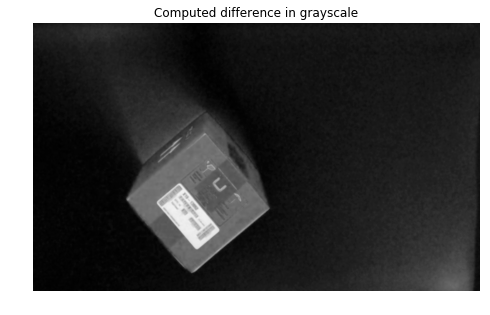

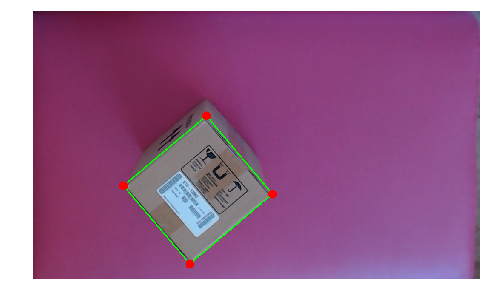

[INFO] Box [[ 212.  410.]
 [ 407.  246.]
 [ 562.  430.]
 [ 368.  594.]]
36.0
19.6594673266


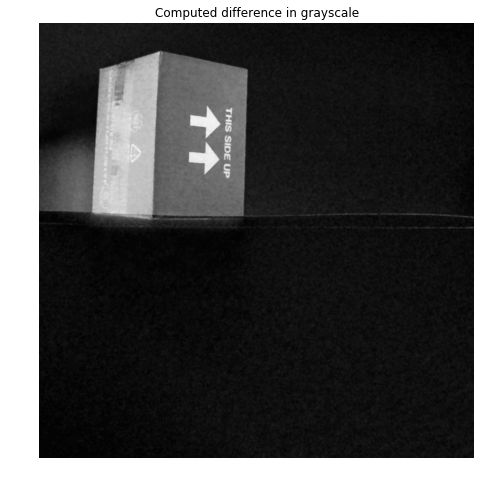

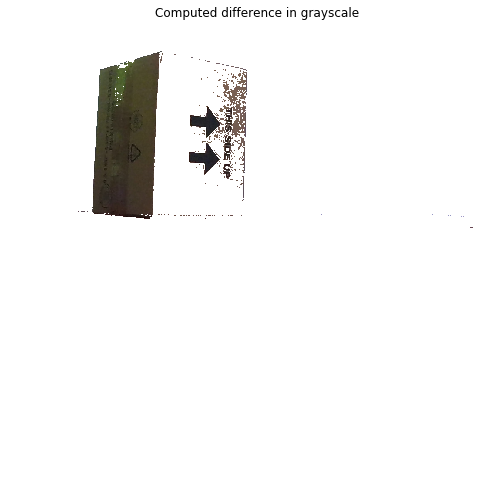

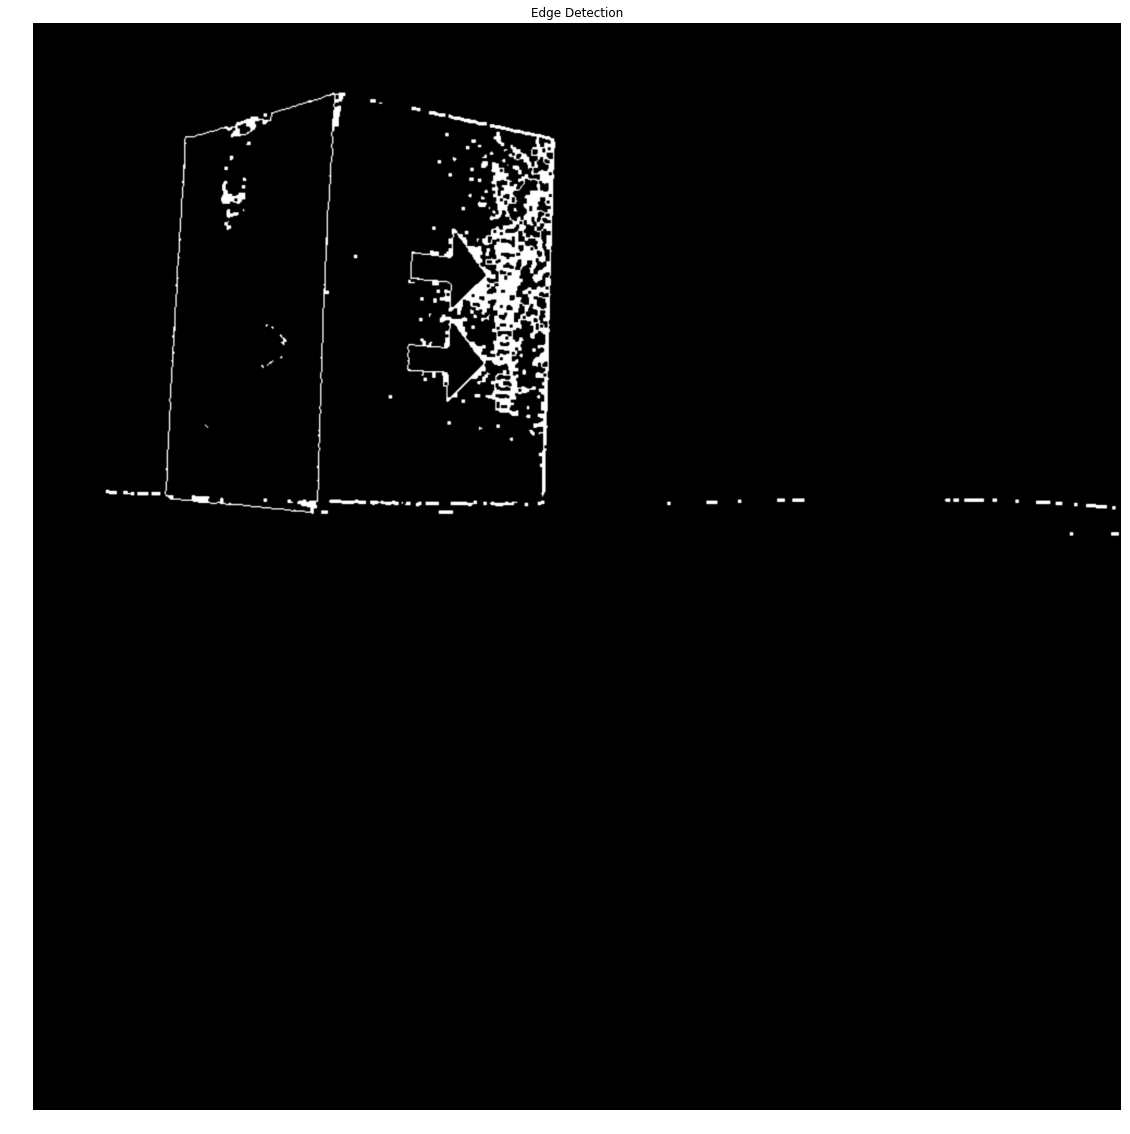

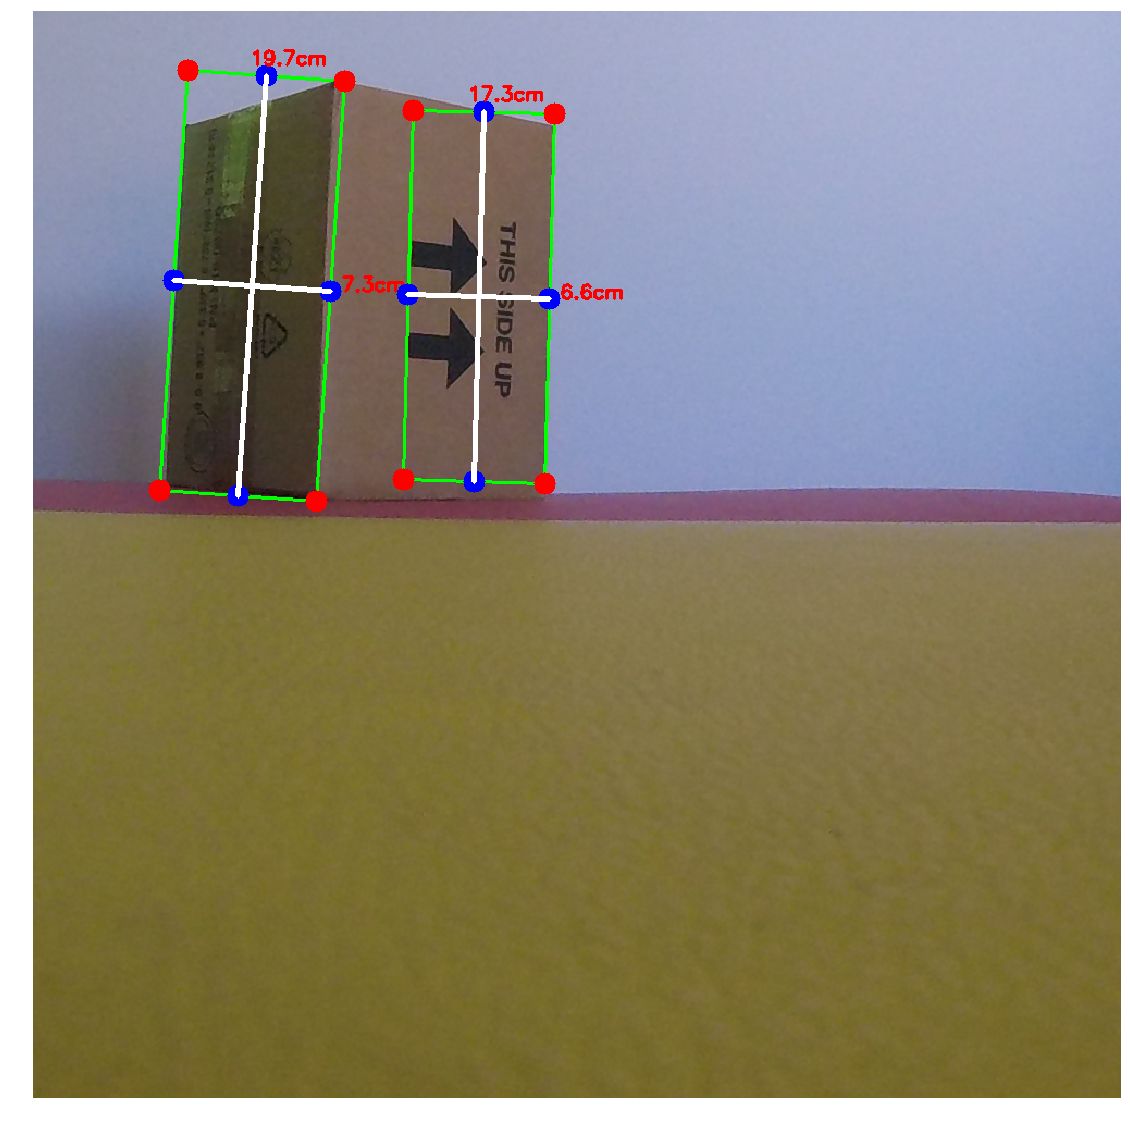

[[array([[ 142.,   55.],
         [ 286.,   65.],
         [ 260.,  451.],
         [ 116.,  441.]], dtype=float32),
  7.3423558333710268,
  19.678796494224262],
 [array([[ 349.,   92.],
         [ 479.,   95.],
         [ 470.,  435.],
         [ 340.,  431.]], dtype=float32),
  6.6149862908085302,
  17.275100412719691]]

In [96]:
x = calculatePixelDistance(top, bg_top, 40)
print(x)
ppm = calculatePpm(x, side_m, side_b)
print(ppm)
calculateSize(side, bg_side, ppm, 50)